<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [29]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import datetime as dt

In [3]:
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [4]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
# !git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

# data_dir='Transfer-Learning-COVID-19/dataset_3_classes/'


In [7]:
# train_loader = torch.utils.data.DataLoader(
#              torch.utils.data.ConcatDataset([
#                  torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "train/"), transform=transform),
#                  torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "test/"), transform=transform)]
#              ),
#              batch_size=64,
#              num_workers=2, shuffle=True)

In [8]:
# print(len(train_loader.dataset))

In [9]:
# img_dim=64
# N_rot=3
# N_flip=5
# N_tran=7
# N_scal=3
# transform_list=[]

# transform_list.append(transforms.Resize((img_dim*2,img_dim*2),interpolation=2))

# for i in range(N_rot):
#   transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-90,90))], p=0.5))
# for i in range(N_flip):
#   transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
# for i in range(N_flip):
#   transform_list.append(transforms.RandomVerticalFlip(p=0.5))
# for i in range(N_scal):
#   transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5))
# for i in range(N_tran):
#   transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,translate=(0.1,0.1))], p=0.5))

# transform_list.append(transforms.Resize((img_dim,img_dim),interpolation=2))

# transform_list.append(transforms.ToTensor())

# transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

# transform = transforms.Compose(transform_list)

# transform = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [14]:
batch_size_train=64
batch_size_test=36
#data_dir = 'custom_covid_dataset/classic_augment/3_classes'
data_dir = 'custom_covid_dataset/classic_augment/4_classes'

img_dim=64
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
transform2 = transforms.Compose([transforms.Resize((img_dim,img_dim)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

trainset0 = torchvision.datasets.ImageFolder(os.path.join(
          data_dir, "0/"), transform=transform)
# trainset500 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "500/"), transform=transform)
# trainset1000 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "1000/"), transform=transform)
# trainset2000 = torchvision.datasets.ImageFolder(os.path.join(
#           data_dir, "2000/"), transform=transform)
listdataset = [trainset0]
trainloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(listdataset), 
                                          batch_size=batch_size_train, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join( 
          data_dir, "test/"), transform=transform)
# testset2 = torchvision.datasets.ImageFolder(os.path.join( 
#           'custom_covid_dataset/', "more_covid_samples/"), transform=transform2)
testloader = torch.utils.data.DataLoader(
          torch.utils.data.ConcatDataset([testset]), batch_size=batch_size_test, shuffle=False)

classes = ("covid", "normal", "pneumonia_bac", "pneumonia_vir")

In [15]:
print(len(trainloader.dataset))

270


In [16]:
print(len(testloader.dataset))

36


In [17]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img_=np.transpose(npimg, (1, 2, 0))
    if img_.shape[2]==1:
      img_=img_[:,:,0]
    plt.imshow(img_)
    plt.show()


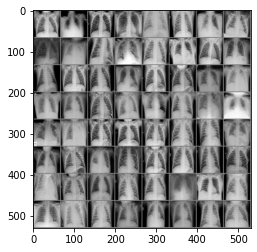

normal covid normal covid pneumonia_vir pneumonia_vir covid normal pneumonia_vir pneumonia_bac pneumonia_vir covid pneumonia_vir covid normal covid pneumonia_vir normal pneumonia_vir covid normal normal covid pneumonia_vir covid pneumonia_bac pneumonia_vir pneumonia_bac covid pneumonia_bac covid covid covid pneumonia_bac normal normal normal pneumonia_vir pneumonia_bac covid pneumonia_bac normal pneumonia_bac pneumonia_vir normal pneumonia_vir pneumonia_vir normal pneumonia_bac normal pneumonia_bac pneumonia_bac pneumonia_vir covid covid pneumonia_bac covid pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir normal


In [18]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size_train)))

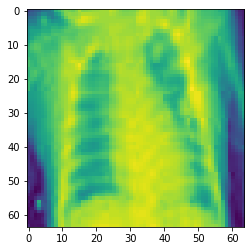

In [19]:
imshow(images[np.random.randint(0,batch_size_train)])

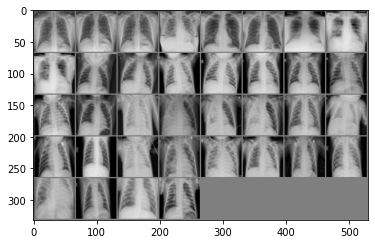

GroundTruth:  covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir


In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size_test)))

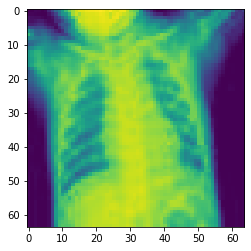

In [21]:
imshow(images[np.random.randint(0,batch_size_test)])

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(self.hidden_size * 4 * img_dim/8 * img_dim/8), img_dim*4),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(img_dim*4, class_number),
            nn.Softmax(dim=1)
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size, class_number):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size = channels_size
        self.class_number = class_number
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [25]:
hidden_size=32
channels_size=1
class_number=4

net=CNN(hidden_size, channels_size, class_number)

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
epochs=150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

summary(net, (channels_size, img_dim, img_dim))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        MaxPool2d-12            [-1, 128, 8, 8]               0
          Flatten-13                 [-1, 8192]               0
           Linear-14            


Epoch: [1]  => Loss: [0.746]



Epoch: [2]  => Loss: [0.747]



Epoch: [3]  => Loss: [0.747]



Epoch: [4]  => Loss: [0.747]



Epoch: [5]  => Loss: [0.747]



Epoch: [6]  => Loss: [0.748]



Epoch: [7]  => Loss: [0.747]



Epoch: [8]  => Loss: [0.746]



Epoch: [9]  => Loss: [0.748]



Epoch: [10]  => Loss: [0.747]



Epoch: [10]  => Test: [1]  => Loss: [0.974]
Epoch: [10]  => Confusion Matrix Test: [1]  => Total Accuracy: [0.806]


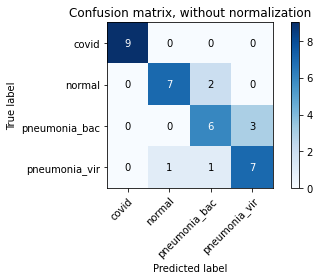

Epoch: [10]  => Evaluation Confusion Matrix Test: [1]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.875    │      0.777778 │      0.95     │  0.823529 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.666667 │      0.666667 │      0.857143 │  0.666667 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.7      │      0.777778 │      0.85     │  0.736842 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [11]  => Loss: [0.747]



Epoch: [12]  => Loss: [0.747]



Epoch: [13]  => Loss: [0.747]



Epoch: [14]  => Loss: [0.748]



Epoch: [15]  => Loss: [0.746]



Epoch: [16]  => Loss: [0.748]



Epoch: [17]  => Loss: [0.748]



Epoch: [18]  => Loss: [0.746]



Epoch: [19]  => Loss: [0.747]



Epoch: [20]  => Loss: [0.747]



Epoch: [20]  => Test: [2]  => Loss: [0.951]
Epoch: [20]  => Confusion Matrix Test: [2]  => Total Accuracy: [0.778]


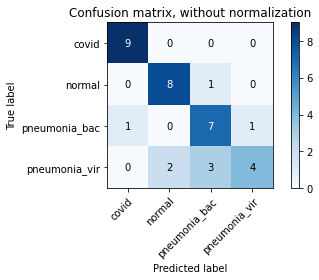

Epoch: [20]  => Evaluation Confusion Matrix Test: [2]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.9      │      1        │      0.944444 │  0.947368 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.8      │      0.888889 │      0.894737 │  0.842105 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.636364 │      0.777778 │      0.8      │  0.7      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.8      │      0.444444 │      0.956522 │  0.571429 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [21]  => Loss: [0.746]



Epoch: [22]  => Loss: [0.746]



Epoch: [23]  => Loss: [0.747]



Epoch: [24]  => Loss: [0.746]



Epoch: [25]  => Loss: [0.746]



Epoch: [26]  => Loss: [0.746]



Epoch: [27]  => Loss: [0.747]



Epoch: [28]  => Loss: [0.746]



Epoch: [29]  => Loss: [0.746]



Epoch: [30]  => Loss: [0.746]



Epoch: [30]  => Test: [3]  => Loss: [0.985]
Epoch: [30]  => Confusion Matrix Test: [3]  => Total Accuracy: [0.750]


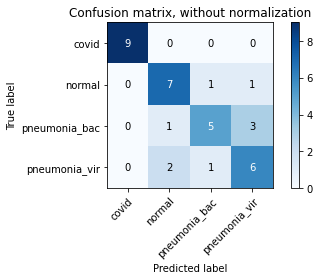

Epoch: [30]  => Evaluation Confusion Matrix Test: [3]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.7      │      0.777778 │      0.85     │  0.736842 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.714286 │      0.555556 │      0.909091 │  0.625    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.6      │      0.666667 │      0.809524 │  0.631579 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [31]  => Loss: [0.746]



Epoch: [32]  => Loss: [0.746]



Epoch: [33]  => Loss: [0.746]



Epoch: [34]  => Loss: [0.746]



Epoch: [35]  => Loss: [0.746]



Epoch: [36]  => Loss: [0.746]



Epoch: [37]  => Loss: [0.747]



Epoch: [38]  => Loss: [0.745]



Epoch: [39]  => Loss: [0.746]



Epoch: [40]  => Loss: [0.746]



Epoch: [40]  => Test: [4]  => Loss: [0.969]
Epoch: [40]  => Confusion Matrix Test: [4]  => Total Accuracy: [0.778]


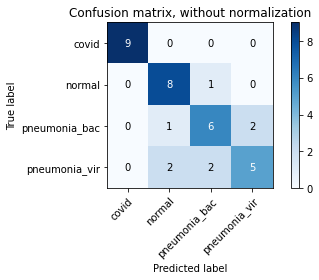

Epoch: [40]  => Evaluation Confusion Matrix Test: [4]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.727273 │      0.888889 │      0.842105 │  0.8      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.666667 │      0.666667 │      0.857143 │  0.666667 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.714286 │      0.555556 │      0.909091 │  0.625    │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [41]  => Loss: [0.745]



Epoch: [42]  => Loss: [0.746]



Epoch: [43]  => Loss: [0.746]



Epoch: [44]  => Loss: [0.746]



Epoch: [45]  => Loss: [0.746]



Epoch: [46]  => Loss: [0.745]



Epoch: [47]  => Loss: [0.746]



Epoch: [48]  => Loss: [0.745]



Epoch: [49]  => Loss: [0.746]



Epoch: [50]  => Loss: [0.747]



Epoch: [50]  => Test: [5]  => Loss: [0.959]
Epoch: [50]  => Confusion Matrix Test: [5]  => Total Accuracy: [0.778]


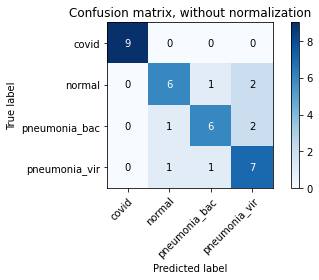

Epoch: [50]  => Evaluation Confusion Matrix Test: [5]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.75     │      0.666667 │      0.904762 │  0.705882 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.75     │      0.666667 │      0.904762 │  0.705882 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.636364 │      0.777778 │      0.8      │  0.7      │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [51]  => Loss: [0.746]



Epoch: [52]  => Loss: [0.746]



Epoch: [53]  => Loss: [0.746]



Epoch: [54]  => Loss: [0.745]



Epoch: [55]  => Loss: [0.746]



Epoch: [56]  => Loss: [0.746]



Epoch: [57]  => Loss: [0.745]



Epoch: [58]  => Loss: [0.745]



Epoch: [59]  => Loss: [0.746]



Epoch: [60]  => Loss: [0.747]



Epoch: [60]  => Test: [6]  => Loss: [0.986]
Epoch: [60]  => Confusion Matrix Test: [6]  => Total Accuracy: [0.778]


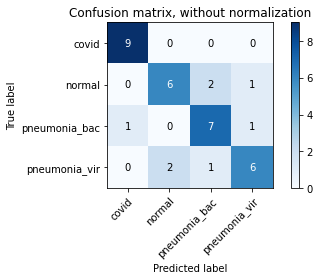

Epoch: [60]  => Evaluation Confusion Matrix Test: [6]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │       0.9  │      1        │      0.944444 │  0.947368 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │       0.75 │      0.666667 │      0.904762 │  0.705882 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │       0.7  │      0.777778 │      0.85     │  0.736842 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │       0.75 │      0.666667 │      0.904762 │  0.705882 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [61]  => Loss: [0.746]



Epoch: [62]  => Loss: [0.746]



Epoch: [63]  => Loss: [0.746]



Epoch: [64]  => Loss: [0.745]



Epoch: [65]  => Loss: [0.746]



Epoch: [66]  => Loss: [0.745]



Epoch: [67]  => Loss: [0.746]



Epoch: [68]  => Loss: [0.745]



Epoch: [69]  => Loss: [0.745]



Epoch: [70]  => Loss: [0.745]



Epoch: [70]  => Test: [7]  => Loss: [0.974]
Epoch: [70]  => Confusion Matrix Test: [7]  => Total Accuracy: [0.750]


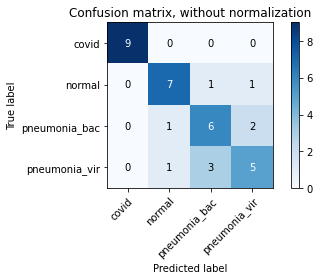

Epoch: [70]  => Evaluation Confusion Matrix Test: [7]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.777778 │      0.777778 │      0.9      │  0.777778 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.6      │      0.666667 │      0.809524 │  0.631579 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.625    │      0.555556 │      0.863636 │  0.588235 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [71]  => Loss: [0.745]



Epoch: [72]  => Loss: [0.749]



Epoch: [73]  => Loss: [0.746]



Epoch: [74]  => Loss: [0.748]



Epoch: [75]  => Loss: [0.745]



Epoch: [76]  => Loss: [0.747]



Epoch: [77]  => Loss: [0.746]



Epoch: [78]  => Loss: [0.746]



Epoch: [79]  => Loss: [0.745]



Epoch: [80]  => Loss: [0.745]



Epoch: [80]  => Test: [8]  => Loss: [0.957]
Epoch: [80]  => Confusion Matrix Test: [8]  => Total Accuracy: [0.806]


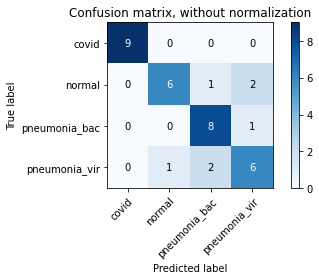

Epoch: [80]  => Evaluation Confusion Matrix Test: [8]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.857143 │      0.666667 │      0.952381 │  0.75     │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.727273 │      0.888889 │      0.842105 │  0.8      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.666667 │      0.666667 │      0.857143 │  0.666667 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [81]  => Loss: [0.746]



Epoch: [82]  => Loss: [0.746]



Epoch: [83]  => Loss: [0.746]



Epoch: [84]  => Loss: [0.745]



Epoch: [85]  => Loss: [0.746]



Epoch: [86]  => Loss: [0.746]



Epoch: [87]  => Loss: [0.745]



Epoch: [88]  => Loss: [0.745]



Epoch: [89]  => Loss: [0.745]



Epoch: [90]  => Loss: [0.745]



Epoch: [90]  => Test: [9]  => Loss: [1.011]
Epoch: [90]  => Confusion Matrix Test: [9]  => Total Accuracy: [0.722]


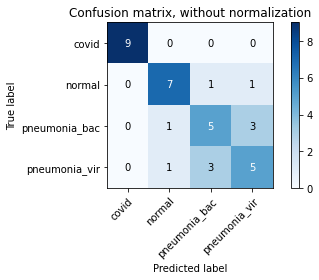

Epoch: [90]  => Evaluation Confusion Matrix Test: [9]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.777778 │      0.777778 │      0.9      │  0.777778 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.555556 │      0.555556 │      0.818182 │  0.555556 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.555556 │      0.555556 │      0.818182 │  0.555556 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [91]  => Loss: [0.745]



Epoch: [92]  => Loss: [0.745]



Epoch: [93]  => Loss: [0.746]



Epoch: [94]  => Loss: [0.746]



Epoch: [95]  => Loss: [0.745]



Epoch: [96]  => Loss: [0.745]



Epoch: [97]  => Loss: [0.745]



Epoch: [98]  => Loss: [0.745]



Epoch: [99]  => Loss: [0.745]



Epoch: [100]  => Loss: [0.745]



Epoch: [100]  => Test: [10]  => Loss: [0.939]
Epoch: [100]  => Confusion Matrix Test: [10]  => Total Accuracy: [0.833]


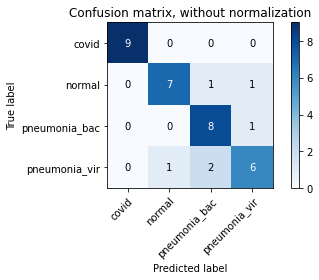

Epoch: [100]  => Evaluation Confusion Matrix Test: [10]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.875    │      0.777778 │      0.95     │  0.823529 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.727273 │      0.888889 │      0.842105 │  0.8      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.75     │      0.666667 │      0.904762 │  0.705882 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [101]  => Loss: [0.745]



Epoch: [102]  => Loss: [0.746]



Epoch: [103]  => Loss: [0.746]



Epoch: [104]  => Loss: [0.745]



Epoch: [105]  => Loss: [0.745]



Epoch: [106]  => Loss: [0.745]



Epoch: [107]  => Loss: [0.745]



Epoch: [108]  => Loss: [0.745]



Epoch: [109]  => Loss: [0.745]



Epoch: [110]  => Loss: [0.744]



Epoch: [110]  => Test: [11]  => Loss: [0.985]
Epoch: [110]  => Confusion Matrix Test: [11]  => Total Accuracy: [0.778]


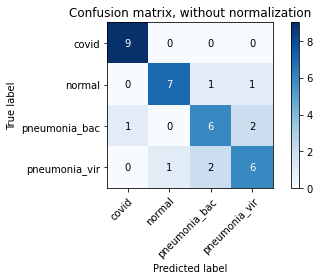

Epoch: [110]  => Evaluation Confusion Matrix Test: [11]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   0.9      │      1        │      0.944444 │  0.947368 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.875    │      0.777778 │      0.95     │  0.823529 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.666667 │      0.666667 │      0.857143 │  0.666667 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.666667 │      0.666667 │      0.857143 │  0.666667 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [111]  => Loss: [0.746]



Epoch: [112]  => Loss: [0.745]



Epoch: [113]  => Loss: [0.745]



Epoch: [114]  => Loss: [0.745]



Epoch: [115]  => Loss: [0.745]



Epoch: [116]  => Loss: [0.745]



Epoch: [117]  => Loss: [0.745]



Epoch: [118]  => Loss: [0.745]



Epoch: [119]  => Loss: [0.746]



Epoch: [120]  => Loss: [0.745]



Epoch: [120]  => Test: [12]  => Loss: [0.949]
Epoch: [120]  => Confusion Matrix Test: [12]  => Total Accuracy: [0.806]


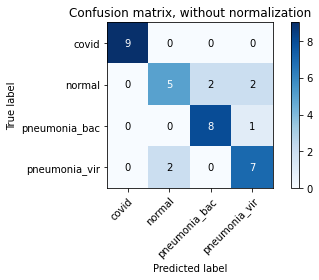

Epoch: [120]  => Evaluation Confusion Matrix Test: [12]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.714286 │      0.555556 │      0.909091 │  0.625    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.8      │      0.888889 │      0.894737 │  0.842105 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.7      │      0.777778 │      0.85     │  0.736842 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [121]  => Loss: [0.745]



Epoch: [122]  => Loss: [0.745]



Epoch: [123]  => Loss: [0.745]



Epoch: [124]  => Loss: [0.745]



Epoch: [125]  => Loss: [0.745]



Epoch: [126]  => Loss: [0.745]



Epoch: [127]  => Loss: [0.745]



Epoch: [128]  => Loss: [0.745]



Epoch: [129]  => Loss: [0.745]



Epoch: [130]  => Loss: [0.745]



Epoch: [130]  => Test: [13]  => Loss: [0.987]
Epoch: [130]  => Confusion Matrix Test: [13]  => Total Accuracy: [0.722]


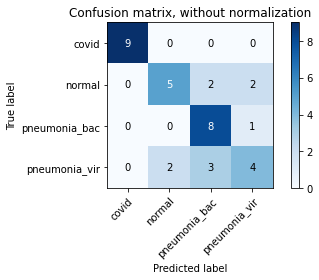

Epoch: [130]  => Evaluation Confusion Matrix Test: [13]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.714286 │      0.555556 │      0.909091 │  0.625    │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.615385 │      0.888889 │      0.736842 │  0.727273 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.571429 │      0.444444 │      0.869565 │  0.5      │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [131]  => Loss: [0.745]



Epoch: [132]  => Loss: [0.745]



Epoch: [133]  => Loss: [0.745]



Epoch: [134]  => Loss: [0.745]



Epoch: [135]  => Loss: [0.745]



Epoch: [136]  => Loss: [0.745]



Epoch: [137]  => Loss: [0.745]



Epoch: [138]  => Loss: [0.745]



Epoch: [139]  => Loss: [0.745]



Epoch: [140]  => Loss: [0.745]



Epoch: [140]  => Test: [14]  => Loss: [1.001]
Epoch: [140]  => Confusion Matrix Test: [14]  => Total Accuracy: [0.722]


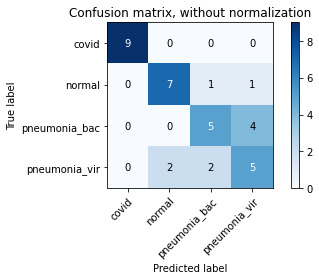

Epoch: [140]  => Evaluation Confusion Matrix Test: [14]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.777778 │      0.777778 │      0.9      │  0.777778 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.625    │      0.555556 │      0.863636 │  0.588235 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.5      │      0.555556 │      0.772727 │  0.526316 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛



Epoch: [141]  => Loss: [0.745]



Epoch: [142]  => Loss: [0.745]



Epoch: [143]  => Loss: [0.745]



Epoch: [144]  => Loss: [0.745]



Epoch: [145]  => Loss: [0.745]



Epoch: [146]  => Loss: [0.745]



Epoch: [147]  => Loss: [0.745]



Epoch: [148]  => Loss: [0.745]



Epoch: [149]  => Loss: [0.745]



Epoch: [150]  => Loss: [0.746]



Epoch: [150]  => Test: [15]  => Loss: [1.001]
Epoch: [150]  => Confusion Matrix Test: [15]  => Total Accuracy: [0.750]


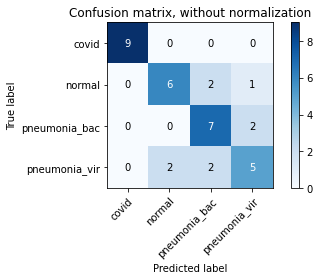

Epoch: [150]  => Evaluation Confusion Matrix Test: [15]
╒═══════════════╤════════════╤═══════════════╤═══════════════╤═══════════╕
│               │   Accuracy │   Sensitivity │   Specificity │   F1Score │
╞═══════════════╪════════════╪═══════════════╪═══════════════╪═══════════╡
│ covid         │   1        │      1        │      1        │  1        │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ normal        │   0.75     │      0.666667 │      0.904762 │  0.705882 │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_bac │   0.636364 │      0.777778 │      0.8      │  0.7      │
├───────────────┼────────────┼───────────────┼───────────────┼───────────┤
│ pneumonia_vir │   0.625    │      0.555556 │      0.863636 │  0.588235 │
╘═══════════════╧════════════╧═══════════════╧═══════════════╧═══════════╛
Finished Training


In [30]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in notebook.tqdm(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        
        gc.collect()
        if torch.cuda.is_available():
            inputs, labels = data[0].cuda(), data[1].cuda()  
        else:
            inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print("Epoch: [%d]"%(epoch + 1),' => Loss: [%.3f]' %(running_loss / len(trainloader)))
    running_loss = 0.0
    if (epoch+1)%10==0:
        running_loss_=0
        with torch.no_grad():
            for data in notebook.tqdm(testloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                outputs = net(inputs)

                _, predicted = torch.max(outputs, 1)

                loss = criterion(outputs, labels)

                running_loss_ += loss.item()

                cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)
                
                tot_acc=np.trace(cm)/np.sum(cm)

                sensitivity = list(0. for i in range(cm.shape[0]))
                specificity = list(0. for i in range(cm.shape[0]))
                accuracy = list(0. for i in range(cm.shape[0]))
                f1score = list(0. for i in range(cm.shape[0]))
                table = list(0. for i in range(cm.shape[0]))

                for i in range(cm.shape[0]):
                    TP = cm[i,i]
                    FN = np.sum(cm[i,:]) - cm[i,i]
                    FP = np.sum(cm[:,i]) - cm[i,i]
                    TN = (np.sum(cm)-np.sum(cm[i,:])-np.sum(cm[:,i]))
                    FP = np.sum(cm[:,i]) - cm[i,i]
                    accuracy[i] = TP/ (TP + FP) 
                    sensitivity[i] = TP/ (TP + FN) 
                    specificity[i] = TN /(TN + FP) 
                    f1score[i]= 2*(accuracy[i]*sensitivity[i])/(accuracy[i]+sensitivity[i])
                    table[i]=[classes[i], accuracy[i], sensitivity[i], specificity[i], f1score[i]]
            
            print("Epoch: [%d]"%(epoch + 1)," => Test: [%d]" %(int((epoch+1)/10)),' => Loss: [%.3f]' %(running_loss_ / len(testloader)))
            
            print("Epoch: [%d]"%(epoch + 1)," => Confusion Matrix Test: [%d]" %(int((epoch+1)/10))," => Total Accuracy: [%.3f]" %(tot_acc))

            plot_confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), classes=np.asarray(classes), normalize=False)

            plt.show()

            print("Epoch: [%d]"%(epoch + 1)," => Evaluation Confusion Matrix Test: [%d]" %(int((epoch+1)/10)))

            print(tabulate(table, headers=['Accuracy','Sensitivity', 'Specificity', 'F1Score'], tablefmt='fancy_grid'))

print('Finished Training')
PATH = './CNN_CLASSIC_'+str(channels_size)+'c_D'+str(len(listdataset))+'_{}.pth'.format(dt.datetime.now())
torch.save(net.state_dict(), PATH)

In [118]:
# net.load_state_dict(torch.load(PATH))
# net.eval()

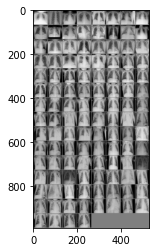

GroundTruth:  covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumon

In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size_test)))

In [34]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size_test)))

Predicted:  covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid covid pneumonia_bac covid covid covid covid covid covid covid covid covid covid covid covid normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal pneumonia_vir pneumonia_bac normal pneumonia_bac normal pneumonia_bac normal normal normal pneumonia_bac normal normal pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_bac pneumonia_vir pneumonia_bac pneumonia_vir pneumonia_vir covid pneumonia_vir pneumonia_vir covid pneumonia_vir pneumonia_bac normal pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pneumonia_vir pne

In [35]:
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, target_names=classes, digits=3))

               precision    recall  f1-score   support

        covid      0.933     0.966     0.949        29
       normal      0.923     0.828     0.873        29
pneumonia_bac      0.562     0.621     0.590        29
pneumonia_vir      0.571     0.552     0.561        29

     accuracy                          0.741       116
    macro avg      0.748     0.741     0.743       116
 weighted avg      0.748     0.741     0.743       116



[[28  0  1  0]
 [ 0 24  4  1]
 [ 0  0 18 11]
 [ 2  2  9 16]]


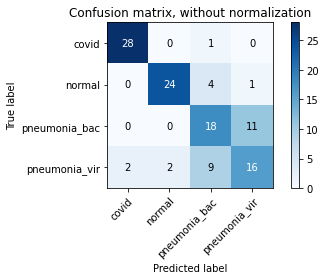

In [36]:
cm = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), labels=None, sample_weight=None)

print(cm)

plot_confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), classes=np.asarray(classes), normalize=False)

Reference to estimated values

<img src="https://devopedia.org/images/article/208/6541.1566280388.jpg" alt="Drawing" width= '400px'/>


In [37]:
tot_acc=np.trace(cm)/np.sum(cm)

sensitivity = list(0. for i in range(cm.shape[0]))
specificity = list(0. for i in range(cm.shape[0]))

for i in range(cm.shape[0]):
  TP = cm[i,i]
  FN = np.sum(cm[i,:]) - cm[i,i]
  TN = (np.sum(cm)-np.sum(cm[i,:])-np.sum(cm[:,i]))
  FP = np.sum(cm[:,i]) - cm[i,i]
  sensitivity[i]= TP/ (TP + FN) 
  specificity[i]= TN /(TN + FP) 
  print("sensitivity for class ",classes[i],": ", sensitivity[i].round(3)) # probability of a positive test given that the patient has the disease
  print("specificity for class ",classes[i],": ", specificity[i].round(3)) # the percentage of healthy people who are correctly identified as not having the condition

# print("total sensitivity: ", (np.sum(sensitivity)/len(classes)).round(3)) # needed?
# print("total specificity: ", (np.sum(specificity)/len(classes)).round(3)) # needed?
print("tot_acc: ",tot_acc.round(3))


sensitivity for class  covid :  0.966
specificity for class  covid :  0.966
sensitivity for class  normal :  0.828
specificity for class  normal :  0.968
sensitivity for class  pneumonia_bac :  0.621
specificity for class  pneumonia_bac :  0.797
sensitivity for class  pneumonia_vir :  0.552
specificity for class  pneumonia_vir :  0.831
tot_acc:  0.741


In [38]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


In [40]:
class_correct = list(0. for i in range(len(classes))) #classes
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size_test): #batch
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of covid : 100 %
Accuracy of normal : 72 %
Accuracy of pneumonia_bac : 58 %
Accuracy of pneumonia_vir : 58 %
